In [18]:
# Question: Can the frequencies of individual bird calls be used to ID species?
# What does a Fourier transform of a bird call look like?

In [19]:
import pandas as pd
import soundfile as sf
import scipy
from scipy.fft import fft, fftfreq, fftshift
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

from IPython.display import Audio

In [20]:
train_df = pd.read_csv("/Users/justinbutler/Documents/Coding_Projects/BIRDCLEF/data/train_metadata.csv")

<Axes: title={'center': 'Number of Calls per Category'}>

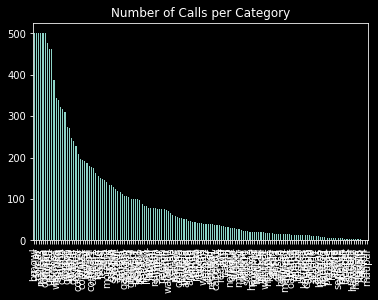

In [21]:
class_count = train_df["primary_label"].value_counts()
class_count.plot(kind='bar', title="Number of Calls per Category")

<Axes: title={'center': 'Number of High Quality Calls per Category'}>

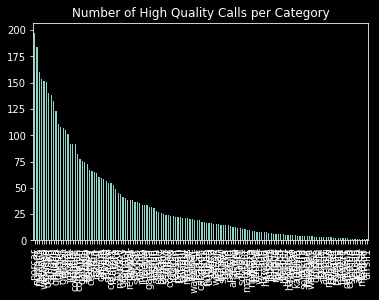

In [22]:
train_df_high_quality = train_df.loc[train_df["rating"] >= 4.5]
class_count_hq = train_df_high_quality["primary_label"].value_counts()
class_count_hq.plot(kind='bar', title='Number of High Quality Calls per Category')

<Axes: title={'center': 'Categories with more than 50 calls'}>

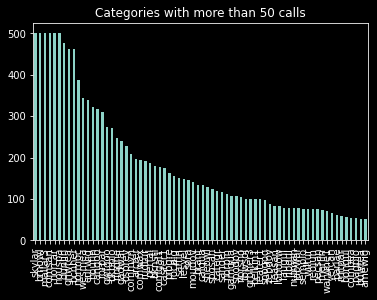

In [23]:
calls_count = 50
categories_greater_than_indices = train_df["primary_label"].value_counts().loc[lambda s: s>calls_count].index.tolist()
train_df_plentiful = train_df.loc[train_df["primary_label"].isin(categories_greater_than_indices)]
train_df_plentiful["primary_label"].value_counts().plot(kind='bar', title=f'Categories with more than {calls_count} calls')

In [24]:
# Nyquest Rate : fs/2 or 1/2T
test_audio1, samplerate1 = sf.read("/Users/justinbutler/Documents/Coding_Projects/BIRDCLEF/data/train_audio/afrsil1/XC125458.ogg")
test_fft1 = fft(test_audio1)
xf1 = np.linspace(0.0, samplerate1/2.0, test_audio1.size//2)
yf1 = 2.0/test_audio1.size * np.abs(test_fft1[:test_audio1.size//2])
audio1_duration_seconds = len(test_audio1) / samplerate1

test_audio2, samplerate2 = sf.read("/Users/justinbutler/Documents/Coding_Projects/BIRDCLEF/data/train_audio/bkbplo/XC25685.ogg")
test_fft2 = fft(test_audio2)
xf2 = np.linspace(0.0, samplerate2/2.0, test_audio2.size//2)
yf2 = 2.0/test_audio2.size * np.abs(test_fft2[:test_audio2.size//2])
audio2_duration_seconds = test_audio2.size / samplerate2

test_audio3, samplerate3 = sf.read("/Users/justinbutler/Documents/Coding_Projects/BIRDCLEF/data/train_audio/hawcre/XC27351.ogg")
test_fft3 = fft(test_audio3)
xf3 = np.linspace(0.0, samplerate3/2.0, test_audio3.size//2)
yf3 = 2.0/test_audio3.size * np.abs(test_fft3[:test_audio3.size//2])

Text(0.5, 1.0, 'Hawaii Creeper')

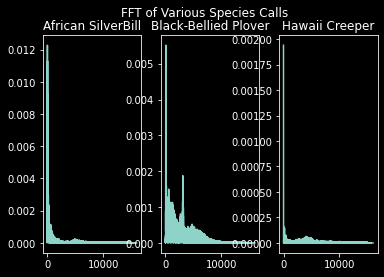

In [25]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle("FFT of Various Species Calls")
ax1.plot(xf1, yf1)
ax1.set_title("African SilverBill")
ax2.plot(xf2, yf2)
ax2.set_title("Black-Bellied Plover")
ax3.plot(xf3, yf3)
ax3.set_title("Hawaii Creeper")


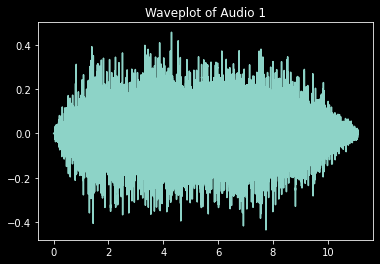

Text(0.5, 1.0, 'FFT of Audio 1 (African SilverBill)')

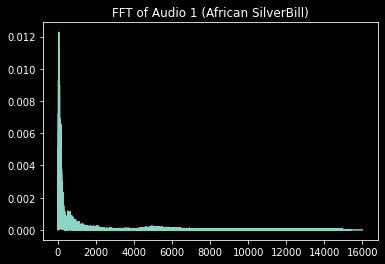

In [26]:
plt.plot(np.linspace(0, audio1_duration_seconds, num=len(test_audio1)), test_audio1)
plt.title('Waveplot of Audio 1')
plt.show()

# Plot FFT of Audio 1
plt.plot(xf1, yf1)
plt.title("FFT of Audio 1 (African SilverBill)")

In [27]:
# To play a sound in Jupyter notebook
# Audio("/Users/justinbutler/Documents/Coding_Projects/BIRDCLEF/data/train_audio/afrsil1/XC125458.ogg")

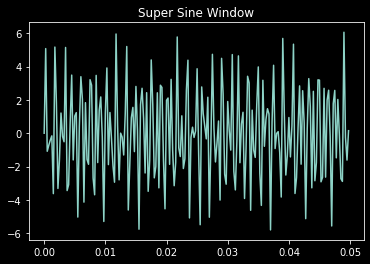

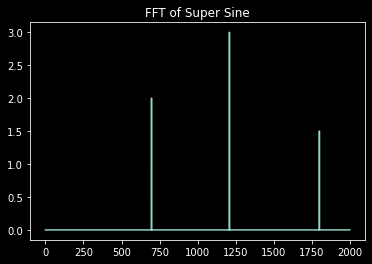

In [28]:
sample_rate_sine   = 4000
sine_duration_seconds = 3.0
sine_samples = np.arange(sine_duration_seconds * sample_rate_sine) / sample_rate_sine
f1_hz = 697
f2_hz = 1209
f3_hz = 1800
# Sine = A*sin(2*pi*f*t+phase)

sine1 = 2*np.sin(2*np.pi*f1_hz*sine_samples).astype(np.float32)
sine2 = 3*np.sin(2*np.pi*f2_hz*sine_samples).astype(np.float32)
sine3 = 1.5*np.sin(2*np.pi*f3_hz*sine_samples).astype(np.float32)

super_sine = sine1 + sine2 + sine3
plt.plot(sine_samples[:200], super_sine[:200])
plt.title("Super Sine Window")
plt.show()

# Plot FFT of Sine
sine_fft = fft(super_sine)
xf_sine = np.linspace(0.0, sample_rate_sine/2.0, super_sine.size//2)
yf_sine = 2.0/super_sine.size * np.abs(sine_fft[:super_sine.size//2])
plt.plot(xf_sine, yf_sine)
plt.title("FFT of Super Sine")
plt.show()

In [29]:
# FT representation does not provide Time information
# But bird calls follow distinct (time-dependent) patterns
# Better to use spectrogram

# Break signal into frames and calculate FT for each frame.
# Frames should overlap so freq. info is not lost
frame_overlap = 0.5
sample_rate_hz = sample_rate_sine
frame_duration_ms = 20
samples = super_sine

# Function test below
frame_size = int(sample_rate_hz * frame_duration_ms * 0.001)
frame_stride_size = int(frame_size * frame_overlap)
max_freq_hz = sample_rate_hz / 2

# Extract windows
# -----------------
# Where to remove the X samples lost from window extraction? Start? End? Split?
# For now, remove X samples from end
to_truncate_size = (samples.size) % frame_stride_size
truncated_samples = samples[:(samples.size - to_truncate_size)]
frame_starts  = np.arange(0,truncated_samples.size, frame_size-frame_stride_size, dtype=int)
frame_starts  = frame_starts[frame_starts + frame_size < samples.size]
print(f'Number of windows: {len(frame_starts)}')

Number of windows: 298


/Users/justinbutler/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


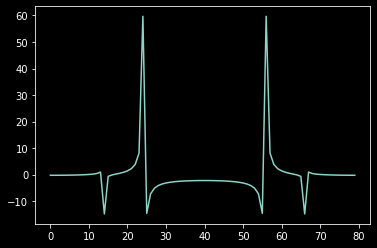

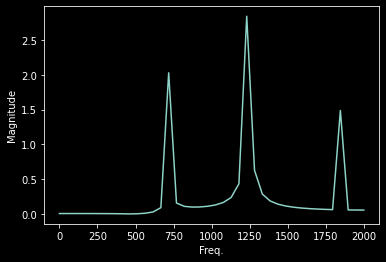

In [30]:
single_window = samples[frame_starts[0]:frame_starts[0]+frame_size]
single_fft = fft(single_window)
plt.plot(single_fft)
plt.show()

single_fft_abs = 2.0/single_window.size * np.abs(single_fft[:single_window.size//2])
xf_sine = np.linspace(0.0, sample_rate_hz/2.0, single_window.size//2)
plt.plot(xf_sine, single_fft_abs)
plt.xlabel('Freq.')
plt.ylabel('Magnitude')
plt.show()

SpecX shape: (40, 298)


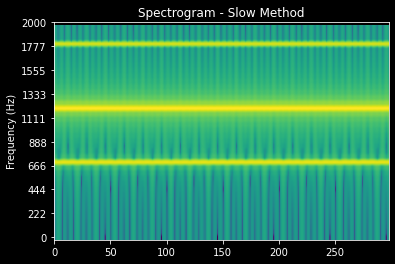

In [31]:
# Slow method
xns = []
for fstart in frame_starts:
    single_window = samples[fstart:fstart+frame_size]
    single_fft = fft(single_window)
    single_fft_abs = 2.0/single_window.size * np.abs(single_fft[:single_window.size//2])
    xns.append(single_fft_abs)
specX = np.array(xns).T
print(f'SpecX shape: {specX.shape}')
spec = 10*np.log10(specX)  # Increase dynamic range

plt.imshow(spec, aspect="auto", origin="lower")
plt.title('Spectrogram - Slow Method')

## create ylim
Nyticks = 10
ks      = np.linspace(0, spec.shape[0], Nyticks)
ksHz    = ks*sample_rate_hz/single_window.size
freq_Hz  = [int(i) for i in ksHz ]
plt.yticks(ks, freq_Hz)
plt.ylabel("Frequency (Hz)")
plt.show()

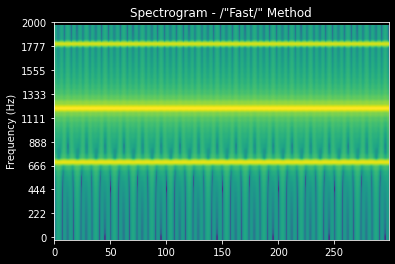

In [32]:
# "Faster" method?
window_view = np.lib.stride_tricks.sliding_window_view(truncated_samples, frame_size)
strided_windows = window_view[::frame_stride_size]
# Apply FFT to all windows at once
# Should apply weighting in fft below
fft_windows = fft(strided_windows)
fft_windows_abs = 2.0/frame_size * np.abs(fft_windows[:, :frame_size//2]).T

spec = (10*np.log10(fft_windows_abs))
plt.imshow(spec, aspect="auto", origin="lower")
plt.title('Spectrogram - /"Fast/" Method')

## create ylim
Nyticks = 10
ks      = np.linspace(0, spec.shape[0], Nyticks)
ksHz    = ks*sample_rate_hz/single_window.size
freq_Hz  = [int(i) for i in ksHz ]
plt.yticks(ks, freq_Hz)
plt.ylabel("Frequency (Hz)")
plt.show()

Text(0.5, 1.0, 'Spectrogram - PyPlot')

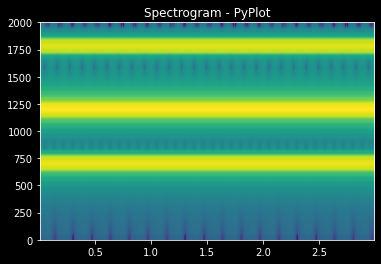

In [33]:
# Built in function example
plt.specgram(samples, Fs=sample_rate_hz, NFFT=frame_size, noverlap=frame_stride_size)
plt.title('Spectrogram - PyPlot')


Possible Learning Methods:
- Learn from Spectrogram (Image-based learning)
- Learn from waveform (transformer? Simple model?)
- Learn from audio?